In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:43267")
client

Client Scheduler: tcp://127.0.0.1:43267 Dashboard: http://127.0.0.1:42503/status,Cluster Workers: 8 Cores: 40 Memory: 168.99 GB


In [2]:
import numpy as np
import xarray as xr
import gsw
import time
from xmitgcm import open_mdsdataset
from xgcm.grid import Grid
from fastjmd95 import rho as densjmd95
import os.path as op
from xhistogram.xarray import histogram as xhist
from scipy.interpolate import griddata
import scipy.sparse as spar
import scipy.signal as spsig
import scipy.ndimage as spimg
import dask_image.ndfilters as dsfilt
import dask.array as dsar
import matplotlib.pyplot as plt
import matplotlib.colors as clr
%matplotlib inline

In [3]:
ddir = '/tank/chaocean/'
savedir = '/tank/topog/tuchida/TWA/'
tdgs = '/tank/tdgs/tuchida/TWA/'

In [4]:
grav = 9.81
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
Cp = 3.994e3
ySstart = -15
yNstart = 10
yend = 50

xchunk = 250
ychunk = 400
membchunk = 1
dnf = 2160
nfile = 73

Let's define buoyancy using an in-situ density anomaly ($\delta = \rho - \underset{\sim}{\rho}(z)$) so that the effect of compressibility be minimized: 

$$\underset{\sim}{b} = -\frac{g}{\rho_0}\delta \equiv \tilde{b}.$$

The question then becomes how to maintain monotonicity without resulting in unphysical overturnings in the buoyancy coordinate ($\tilde{b}_z > 0$). Now, the vertical derivative of the in-situ density using the above notation can be decomposed as:

$$\delta_z = \rho_z - \frac{d}{dz}\underset{\sim}{\rho} = \frac{-\rho_0 g}{c_s^2} - \frac{d}{dz}\underset{\sim}{\rho}.$$

For simplicity, we can write $\frac{d}{dz}\underset{\sim}{\rho} \equiv -\frac{\rho_0 g}{\mathcal{C}_s^2}$ where $\mathcal{C}_s = \mathcal{C}_s(z)$ is a function of $z$, which yields:

$$\tilde{b}_z = -\frac{g}{\rho_0}\delta_z = g^2\frac{\mathcal{C}_s^2 - c_s^2}{c_s^2 \mathcal{C}_s^2}.$$

Hence, so long as $\mathcal{C}_s \gtrsim c_s$, monotonicity is satisfied while removing a large portion of compressiblility, i.e. the isosurfaces of $\tilde{b}$ become close to neutral surfaces. The buoyancy equation using the in-situ buoyancy anomaly becomes:

$$\frac{D\tilde{b}}{Dt} = wg^2\frac{\mathcal{C}_s^2 - c_s^2}{c_s^2 \mathcal{C}_s^2} + \mathcal{B},$$

where the right-hand side can be summarized as the dia-surface velocity $\varpi\equiv wg^2\frac{\mathcal{C}_s^2 - c_s^2}{c_s^2 \mathcal{C}_s^2} + \mathcal{B}$. The TWA framework further requires that the pressure anomaly transforms into a body force in the buoyancy coordinate:

$$\nabla_\text{h}\underset{\sim}{\phi}(\tilde{b}) = \tilde{\nabla}_\text{h} m$$

where $m = \phi - \tilde{b}z$ is the Montgomery potential. Using the in-situ buoyancy anomaly, the pressure anomaly becomes:

$$\underset{\sim}{\phi} = \int \tilde{b} dz,$$

while the pressure anomaly used for a Boussinesq hydrostatic fluid is:

$$\phi = -\frac{g}{\rho_0} \int(\rho - \rho_0) dz.$$

Since $\underset{\sim}{\rho}(z)$ is only a function of $z$, the horizontal gradient of the two remain identical ($\nabla_\text{h}\underset{\sim}{\phi} = \nabla_\text{h}\phi$) and the identity between the Montgomery potential still holds. 
<!-- Now, taking the horizontal gradient on iso-surfaces of $\delta$: -->

<!-- $$0 = \tilde{\nabla}_\text{h}\delta = \rho_\theta\tilde{\nabla}_\text{h}\theta + \rho_s\tilde{\nabla}_\text{h}s + (\rho_\zeta - {\underset{\sim}{\rho}}_\zeta)\tilde{\nabla}_\text{h}\zeta.$$ -->

<!-- For these surfaces to be neutral, the following needs to be satisfied: -->

<!-- $$\rho_\theta\tilde{\nabla}_\text{h}\theta + \rho_s\tilde{\nabla}_\text{h}s = 0$$ -->

<!-- or equivalently $\rho_\zeta - {\underset{\sim}{\rho}}_\zeta \approx 0$. -->

In [5]:
def sound_speed(s,th,p):
    """
    s            : salinity (psu)
    th           : potential temperature (deg C, ITS-90)
    p            : pressure (dbar)
    """
    th2 = th**2
    sqrts = np.sqrt(s)

    anum = ( 9.99843699e2 +
            th *( 7.35212840 +
                 th *(-5.45928211e-2 +
                      th * 3.98476704e-4
                     )
                ) +
            s *( 2.96938239 -
                th * 7.23268813e-3 +
                s * 2.12382341e-3
               )
           )
    aden = (1. +
            th *( 7.28606739e-3 +
                 th *(-4.60835542e-5 +
                      th *( 3.68390573e-7 +
                           th * 1.80809186e-10
                          )
                     )
                ) +
            s *( 2.14691708e-3 -
                th *( 9.27062484e-6 +
                     th2 * 1.78343643e-10
                    ) +
                sqrts *( 4.76534122e-6 +
                        th2 * 1.63410736e-9
                       )
               )
           )
    

    anum_p = ( 1.04004591e-2 +
              th2 * 1.03970529e-7 +
              s * 5.18761880e-6
             )
    aden_p = 5.30848875e-6 * xr.ones_like(s)


    pth = p*th
    anum = anum + p *( 1.04004591e-2 +
                      th2 *  1.03970529e-7 +
                      s *  5.18761880e-6 -
                      p *( 3.24041825e-8 +
                          th2 *  1.23869360e-11
                         )
                     )
    aden = aden + p *( 5.30848875e-6 -
                      pth *(th2 *  3.03175128e-16 +
                            p *  1.27934137e-17
                           )
                     )


    anum_p = anum_p - p *( 6.4808365e-8 + th2 * 2.4773872e-11)

    aden_p = aden_p - pth *(th2 * 6.06350256e-16 +
                            p * 3.83802411e-17)


    rec_aden = aden**-1

    rho = anum*rec_aden
    rho_p = (anum_p - aden_p*rho)*rec_aden
    
    return np.sqrt(rho_p*1e-4)**-1

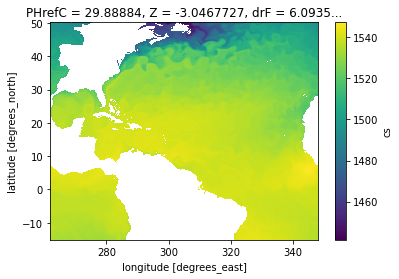

1967


<xarray.DataArray 'cs' (Z: 46)>
array([1553.3113, 1551.662 , 1551.4595, 1550.9567, 1549.8401, 1549.3513,
       1549.4307, 1547.5911, 1547.7415, 1547.0035, 1545.8386, 1545.5991,
       1545.1454, 1544.0189, 1543.6737, 1544.3446, 1545.0837, 1545.9294,
       1536.7858, 1536.2279, 1534.975 , 1529.175 , 1522.0891, 1518.2726,
       1514.6449, 1516.0912, 1507.7091, 1504.6354, 1504.4694, 1505.1969,
       1508.7001, 1508.3672, 1512.1721, 1515.1881, 1519.1094, 1523.1105,
       1527.1263, 1531.2194, 1535.0016, 1539.2003, 1543.464 , 1547.765 ,
       1552.05  , 1556.3431, 1560.45  , 1564.8308], dtype=float32)
Coordinates:
    PHrefC   (Z) float32 29.89 92.74 160.5 ... 5.273e+04 5.518e+04 5.764e+04
  * Z        (Z) float32 -3.047 -9.454 -16.36 ... -5.625e+03 -5.875e+03
    drF      (Z) float32 6.094 6.721 7.099 7.971 ... 248.9 249.6 249.9 250.5
    rhoRef   (Z) float32 1.021e+03 1.021e+03 1.021e+03 ... 1.044e+03 1.044e+03
    iter     int64 1576800
    time     timedelta64[ns] 3650 days

In [6]:
years = np.arange(1967,1968,dtype=int)
ntimes = np.arange(1421280,1576800+dnf,dnf).reshape(len(years),nfile)

yystart = 0
yy = yystart
for year in years[yy:]:

    for itime in ntimes[yy]:
        dsp = xr.open_zarr(op.join(savedir,'PHI_5Dave/run%4d/%010d/' 
                                   % (year,itime))).isel(time=0)
        dsc = xr.open_zarr(op.join(tdgs,'Cs_5Dave/run%4d/%010d/' 
                                   % (year,itime))).isel(time=0)
        
        if itime == ntimes[yy,0]:
            if yy == yystart:
                dsc.cs.sel(nmemb=24).isel(Z=0).plot()
                plt.show()
            Cs = np.maximum(dsp.cs.max(['nmemb','YC','XC'], skipna=True),
                            dsc.cs.max(['nmemb','YC','XC'], skipna=True)
                           ).compute()
#             print(Cs)
        else:
            Cs = np.maximum(Cs, np.maximum(dsp.cs.max(['nmemb','YC','XC'], skipna=True),
                                           dsc.cs.max(['nmemb','YC','XC'], skipna=True)
                                          ).compute()
                           )
        
        dsp.close()
        dsc.close()

    Cs.to_dataset(name='Cs').to_zarr(op.join(tdgs,'5Dave/Max_sound-speed/run%4d/' % year), mode='w')
    
    print(year)
    yy += 1
        
# Cs.to_dataset(name='Cs').to_netcdf(op.join(savedir,'5Dave/Max_sound-speed.nc'))
# Cs.to_dataset(name='Cs').to_netcdf(op.join(tdgs,'5Dave/Max_sound-speed.nc'))
Cs

<xarray.DataArray 'Cs' (Z: 46)>
dask.array<xarray-Cs, shape=(46,), dtype=float32, chunksize=(46,), chunktype=numpy.ndarray>
Coordinates:
    PHrefC   (Z) float32 dask.array<chunksize=(46,), meta=np.ndarray>
  * Z        (Z) float32 -3.047 -9.454 -16.36 ... -5.625e+03 -5.875e+03
    drF      (Z) float32 dask.array<chunksize=(46,), meta=np.ndarray>
    iter     int64 ...
    rhoRef   (Z) float32 dask.array<chunksize=(46,), meta=np.ndarray>
    time     timedelta64[ns] ...

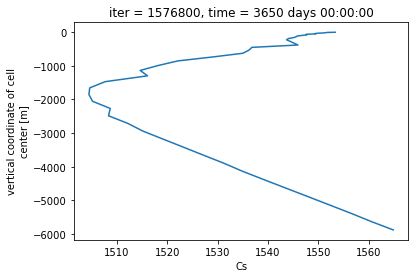

In [7]:
Cs = xr.open_zarr(op.join(tdgs,'5Dave/Max_sound-speed/run1967/')).Cs
Cs.plot(y='Z')
Cs

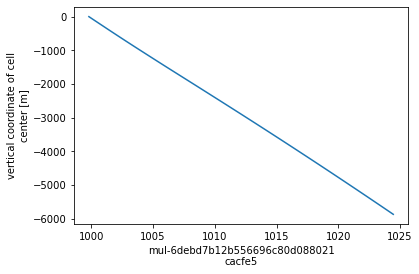

In [8]:
ds = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                             % (0,1967)), 
                     grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                     iters=1421280,
                     prefix=['diag_ocnTave'], delta_t=2e2,
                    ).sel(YC=slice(ySstart-12**-1,yend+2*12**-1),
                          YG=slice(ySstart-12**-1,yend+2*12**-1)
                         ).chunk({'XC':xchunk,'XG':xchunk,
                                  'YC':ychunk,'YG':ychunk})
grid = Grid(ds, periodic=['X'])
rho_til = rhoConst*(1. - grav*grid.interp(-grid.cumsum(Cs**-2*ds.drF,'Z',boundary='fill',to='outer'),
                                          'Z',boundary='fill'))
rho_til.plot(y='Z')

In [27]:
# vol = (ds.hFacC * ds.rA * ds.drF).where(ds.maskC!=0.)
# ds['theta'] = ds.THETA.where(ds.maskC!=0.) - dHT0
# ds['salt'] = ds.SALT.where(ds.maskC!=0.) - dHS0

# t0 = ((theta.mean(['nmemb','time']) * vol).sel(Z=slice(None,-2000)).sum(['Z','YC','XC'], skipna=True)
#       * vol.sel(Z=slice(None,-2000)).sum(['Z','YC','XC'], skipna=True)**-1).compute()
# s0 = ((salt.mean(['nmemb','time']) * vol).sel(Z=slice(None,-2000)).sum(['Z','YC','XC'], skipna=True)
#       * vol.sel(Z=slice(None,-2000)).sum(['Z','YC','XC'], skipna=True)**-1).compute()
# cs = xr.apply_ufunc(sound_speed, ds.salt, ds.theta, -grav*ds.Z*rhoConst*1e-4,
#                     dask='parallelized', output_dtypes=[float,])
cs = sound_speed(ds.salt, ds.theta, -grav*ds.Z*rhoConst*1e-4)
# cs.name = 'sound speed'
cs

<xarray.DataArray (nmemb: 12, time: 293, Z: 46, YC: 783, XC: 1000)>
dask.array<pow, shape=(12, 293, 46, 783, 1000), dtype=float32, chunksize=(1, 1, 46, 200, 200), chunktype=numpy.ndarray>
Coordinates:
    rA       (YC, XC) >f4 dask.array<chunksize=(200, 200), meta=np.ndarray>
    maskC    (Z, YC, XC) bool dask.array<chunksize=(46, 200, 200), meta=np.ndarray>
    Depth    (YC, XC) >f4 dask.array<chunksize=(200, 200), meta=np.ndarray>
    drF      (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    PHrefC   (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    hFacC    (Z, YC, XC) >f4 dask.array<chunksize=(46, 200, 200), meta=np.ndarray>
    maskInC  (YC, XC) bool dask.array<chunksize=(200, 200), meta=np.ndarray>
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * Z        (Z) >f4 -3.0467727 -9.454049 -16.363966 ... -5624.9517 -5875.141
  * nmemb    (nmemb) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * YC       (YC) >f4 -15.0833 -14.999967 -14.916634 ... 50.000034 50.08337
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time     (time) float64 1.888e+08 1.892e+08 ... 3.145e+08 3.149e+08

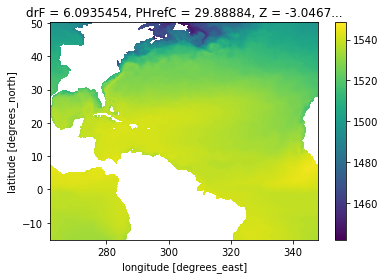

In [28]:
cs.isel(time=0,Z=0).mean('nmemb').plot()

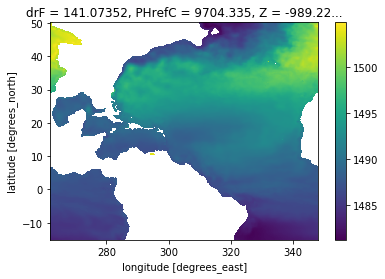

In [29]:
cs.isel(time=0).sel(Z=-1000,method='nearest').mean('nmemb').plot()

From $\frac{d}{dz}\underset{\sim}{\rho} \equiv -\frac{\rho_0 g}{\mathcal{C}_s^2}$, we have:

$$\underset{\sim}{\rho} = -\int_z^0 \frac{\rho_0 g}{\mathcal{C}_s^2} dz + \rho_0,$$

which satisfies $\underset{\sim}{\rho}|_{z=0} = \rho_0$ and

$$\tilde{b} = -\frac{g}{\rho_0}(\rho-\rho_0) - \int_z^0 \frac{g^2}{\mathcal{C}_s^2} dz.$$

In [9]:
ystart = ySstart
nmembs = np.concatenate((np.arange(24),np.arange(36,60)))

for mmemb in nmembs:
    if mmemb == 0:
        ds = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' % (mmemb,1967)), 
                             grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                             prefix=['diag_ocnTave'], 
                             delta_t=2e2, iters=1421280
                            ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                  YG=slice(ystart-12**-1,yend+2*12**-1)
                                 ).isel(time=0).chunk({'XC':xchunk,'XG':xchunk,
                                                       'YC':ychunk,'YG':ychunk})
    else:
        ds = xr.concat([ds,open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                                   % (mmemb,1967)), 
                                           grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                           prefix=['diag_ocnTave'], 
                                           delta_t=2e2, iters=1421280
                                          ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                                YG=slice(ystart-12**-1,yend+2*12**-1)
                                               ).isel(time=0).chunk({'XC':xchunk,'XG':xchunk,
                                                                     'YC':ychunk,'YG':ychunk})
                       ], dim='nmemb')
        
ds.coords['nmemb'] = ('nmemb',range(48))
grid = Grid(ds, periodic=['X'])
theta = ds.THETA.where(ds.maskC!=0.)
salt = ds.SALT.where(ds.maskC!=0.)
        
rho = xr.apply_ufunc(densjmd95, salt, theta,
                     -grav*ds.Z*rhoConst*1e-4,             # pressure in [dbar]!!!!
                     dask='parallelized', output_dtypes=[float,]
                    )

delta = rho - rho_til
ds['delta'] = delta
delta

<xarray.DataArray (nmemb: 48, Z: 46, YC: 783, XC: 1000)>
dask.array<sub, shape=(48, 46, 783, 1000), dtype=float64, chunksize=(1, 45, 400, 250), chunktype=numpy.ndarray>
Coordinates: (12/14)
    iter     int64 1421280
    time     timedelta64[ns] 3290 days
  * XC       (XC) >f4 262.0 262.1 262.2 262.3 262.3 ... 347.7 347.8 347.9 348.0
  * YC       (YC) >f4 -15.08 -15.0 -14.92 -14.83 ... 49.83 49.92 50.0 50.08
  * Z        (Z) >f4 -3.047 -9.454 -16.36 ... -5.375e+03 -5.625e+03 -5.875e+03
    rA       (YC, XC) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    ...       ...
    PHrefC   (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    hFacC    (Z, YC, XC) >f4 dask.array<chunksize=(46, 400, 250), meta=np.ndarray>
    maskC    (Z, YC, XC) bool dask.array<chunksize=(46, 400, 250), meta=np.ndarray>
    maskInC  (YC, XC) bool dask.array<chunksize=(400, 250), meta=np.ndarray>
    rhoRef   (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
  * nmemb    (nmemb) int64 0 1 2 3 4 5 6 7 8 9 ... 38 39 40 41 42 43 44 45 46 47

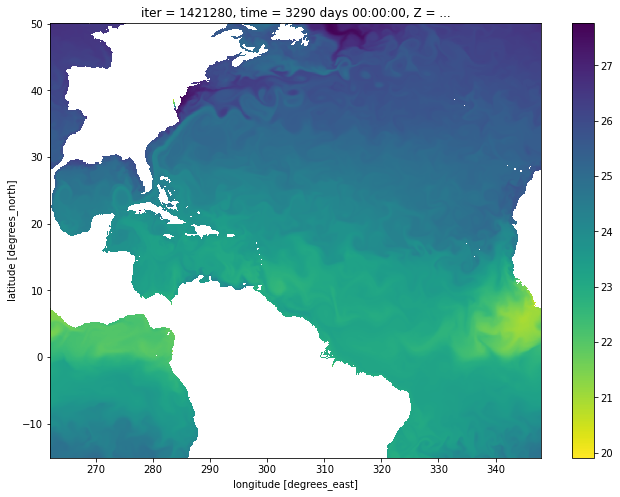

In [10]:
delta.isel(nmemb=0, Z=0).plot(figsize=(11,8), cmap='viridis_r')

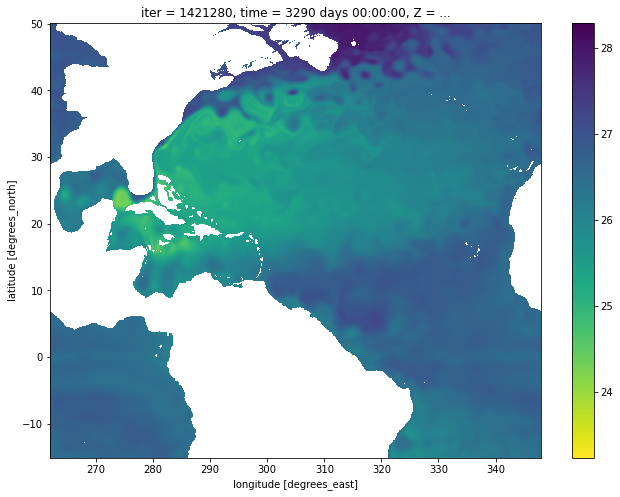

In [11]:
delta.isel(nmemb=0).sel(Z=-200,method='nearest').plot(figsize=(11,8), cmap='viridis_r')

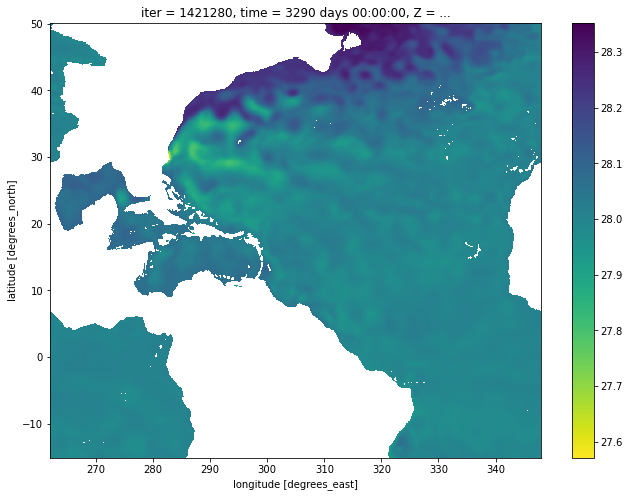

In [12]:
delta.isel(nmemb=0).sel(Z=-1000,method='nearest').plot(figsize=(11,8), cmap='viridis_r')

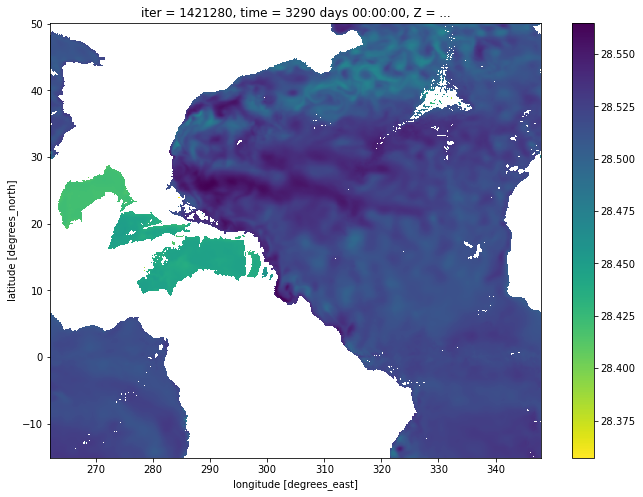

In [13]:
delta.isel(nmemb=0).sel(Z=-2000,method='nearest').plot(figsize=(11,8), cmap='viridis_r')

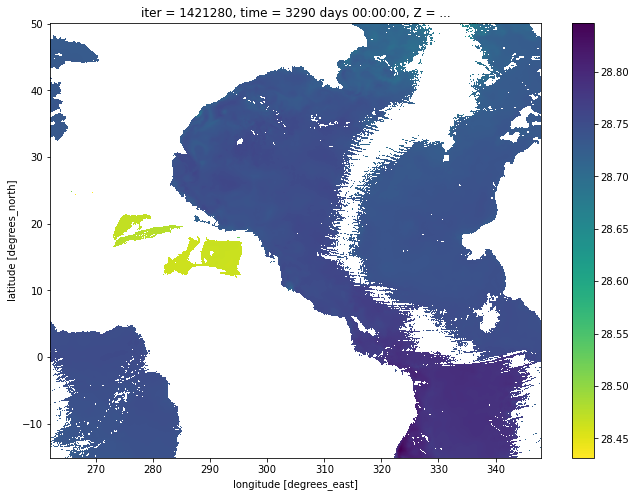

In [19]:
delta.isel(nmemb=0).sel(Z=-4000,method='nearest').plot(figsize=(11,8), cmap='viridis_r')

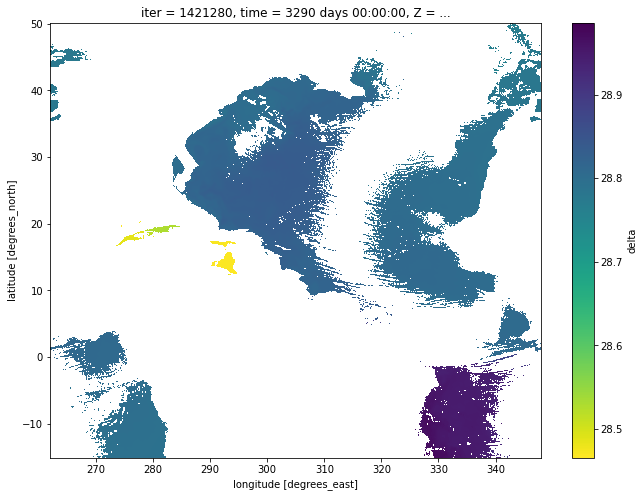

In [21]:
delta.isel(nmemb=0).sel(Z=-5000,method='nearest').plot(figsize=(11,8), cmap='viridis_r')

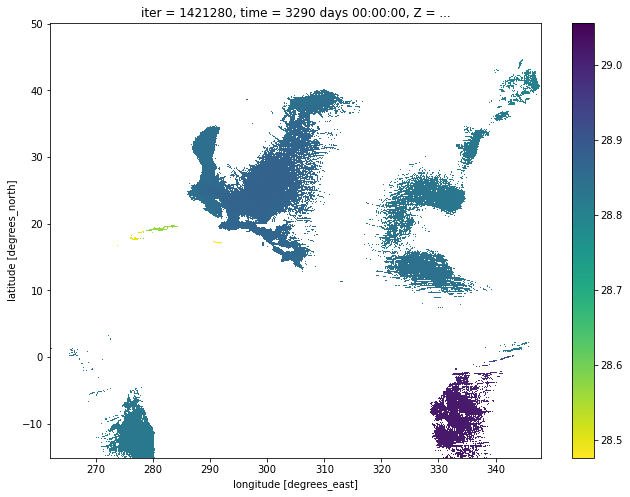

In [14]:
delta.isel(nmemb=0).sel(Z=-5500,method='nearest').plot(figsize=(11,8), cmap='viridis_r')

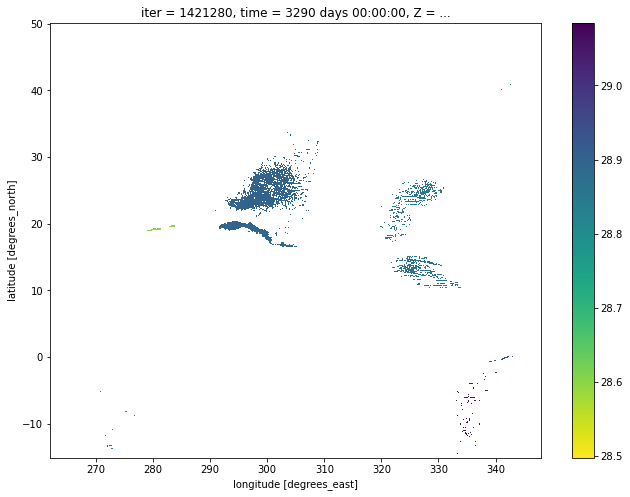

In [15]:
delta.isel(nmemb=0).sel(Z=-5800,method='nearest').plot(figsize=(11,8), cmap='viridis_r')

Text(0.5, 0, '$\\delta$')

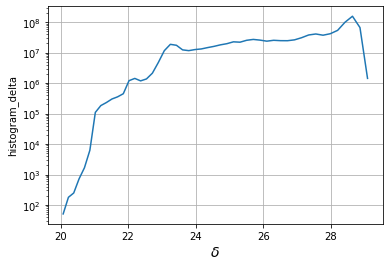

In [22]:
delta.name = 'delta'
# bins = np.linspace(20., 29.2, 40)
bins = np.logspace(np.log10(20.), np.log10(29.2))
h = xhist(delta.sel(Z=slice(None,None)), bins=[bins])
fig, ax = plt.subplots()
h.plot(ax=ax)
ax.set_yscale('log')
ax.grid(True)
ax.set_xlabel(r"$\delta$", fontsize=14)

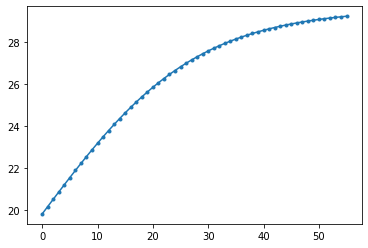

In [21]:
Dsig = 9.2
sigmin = 20.
nlayers = 55
# siglayers = np.linspace(19,48,nlayers)
xs, xe = (0,2)
tanh1 = np.tanh(np.arange(xs,xe,(xe-xs)/nlayers))
amp = (tanh1.max()-tanh1.min())
siglayers = (tanh1-tanh1.min())*amp**-1*Dsig + sigmin
tanh2 = np.tanh(np.arange(xs-(xe-xs)/(2*nlayers),xe+(xe-xs)/(2*nlayers),(xe-xs)/nlayers))
sigp1layers = (tanh2-tanh1.min())*amp**-1*Dsig + sigmin
plt.plot(sigp1layers, '.-')

In [18]:
print(len(np.arange(xs,xe,(xe-xs)/nlayers)),
      len(np.arange(xs-(xe-xs)/(2*nlayers),xe+(xe-xs)/(2*nlayers),(xe-xs)/nlayers)))

70 71


In [23]:
bz = -grav/rhoConst*grid.interp(-grid.diff(delta,'Z',boundary='fill',to='outer')
                                / ds.drC,'Z',boundary='fill')
bz

<xarray.DataArray 'mul-137d29d9381385d770703c261d112ded' (nmemb: 24, Z: 46, YC: 783, XC: 1000)>
dask.array<mul, shape=(24, 46, 783, 1000), dtype=float64, chunksize=(1, 43, 400, 250), chunktype=numpy.ndarray>
Coordinates:
  * nmemb    (nmemb) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23
  * Z        (Z) >f4 -3.0467727 -9.454049 -16.363966 ... -5624.9517 -5875.141
  * YC       (YC) >f4 -15.0833 -14.999967 -14.916634 ... 50.000034 50.08337
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725

Text(0.5, 0, '$b_z$')

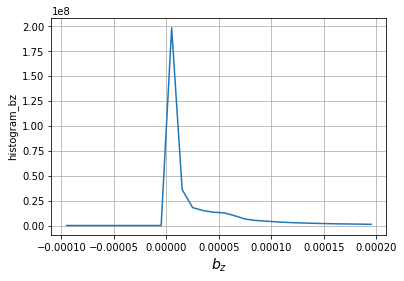

In [24]:
bz.name = 'bz'
bins = np.linspace(-.0001, .0002, 31)
h = xhist(bz.sel(Z=slice(-100,None)), bins=[bins])
fig, ax = plt.subplots()
h.plot(ax=ax)
# ax.set_yscale('log')
ax.grid(True)
ax.set_xlabel(r"$b_z$", fontsize=14)

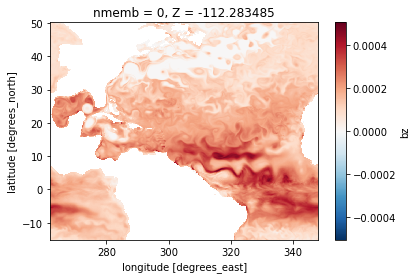

In [25]:
bz.isel(nmemb=0,Z=10).plot()